# 1. Introduction 

Based on the initial testing, as seen in the notebook entitled Modelling.ipynb, the final model that was chosen to be used was random forest classifier. Not only was it able to give decent accuracies without tuning, scikitlearn allows for control over the number of processors being used. This is a good proxy to test out the parallelism capabilities of the model before attempting with Spark ML or other methods of hosting this script on cluster. 

## 1.1 Importing Libraries

In [79]:
from db.conn import create_db_conn
import time
import pandas as pd
import numpy as np 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# Surpress 
#import warnings
#warnings.filterwarnings('ignore')

## 1.2 Preparing the data

This code will directly pull the data from the datawarehouse hosted in AWS.

In [50]:
conn = create_db_conn()
full_table_query = "SELECT * FROM traffic_weather_comb"
df = pd.io.sql.read_sql_query(full_table_query, conn)

c:\users\vik\desktop\cs 4225\project\traffic-predict\.venv\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [51]:
df.head()

,call_timestamp,cam_id,direction,compass,two_hr_forecast_area,non_rainfall_station_id,rainfall_station_id,rainfall_realtime,wind_speed_realtime,wind_dir_realtime,...,twenty_four_hr_period_1_start,twenty_four_hr_period_1_end,twenty_four_hr_period_1,twenty_four_hr_period_2_start,twenty_four_hr_period_2_end,twenty_four_hr_period_2,twenty_four_hr_period_3_start,twenty_four_hr_period_3_end,twenty_four_hr_period_3,trafficcongestion
0,2022-04-09T010159,4799,1,south,Sentosa,S108,S226,0.0,NaN,NaN,...,2022-04-09T000000,2022-04-09T060000,Partly Cloudy (Night),2022-04-09T060000,2022-04-09T120000,Partly Cloudy (Day),2022-04-09T120000,2022-04-09T180000,Partly Cloudy (Day),None
1,2022-04-09T010159,5795,2,east,Geylang,S108,S215,0.0,NaN,NaN,...,2022-04-09T000000,2022-04-09T060000,Partly Cloudy (Night),2022-04-09T060000,2022-04-09T120000,Partly Cloudy (Day),2022-04-09T120000,2022-04-09T180000,Thundery Showers,None
2,2022-04-09T010159,5798,2,central,Geylang,S108,S215,0.0,NaN,NaN,...,2022-04-09T000000,2022-04-09T060000,Partly Cloudy (Night),2022-04-09T060000,2022-04-09T120000,Partly Cloudy (Day),2022-04-09T120000,2022-04-09T180000,Thundery Showers,Medium
3,2022-04-09T010159,6704,1,central,Novena,S108,S90,0.0,NaN,NaN,...,2022-04-09T000000,2022-04-09T060000,Partly Cloudy (Night),2022-04-09T060000,2022-04-09T120000,Partly Cloudy (Day),2022-04-09T120000,2022-04-09T180000,Thundery Showers,Medium
4,2022-04-09T010159,6708,1,west,Jalan Bahar,S44,S44,0.0,NaN,NaN,...,2022-04-09T000000,2022-04-09T060000,Partly Cloudy (Night),2022-04-09T060000,2022-04-09T120000,Partly Cloudy (Day),2022-04-09T120000,2022-04-09T180000,Partly Cloudy (Day),Medium


In [52]:
df = df[df.trafficcongestion != "NaN"]

However, due to schema inference, some of the data types, especially the dates, need to be converted. 

In [53]:
# Converting time from string to date time object
df.call_timestamp = pd.to_datetime(df.call_timestamp)
df["twenty_four_hr_start"] = pd.to_datetime(df["twenty_four_hr_start"])
df["twenty_four_hr_end"] = pd.to_datetime(df["twenty_four_hr_end"])
df["twenty_four_hr_period_1_start"] = pd.to_datetime(df["twenty_four_hr_period_1_start"])
df["twenty_four_hr_period_1_end"] = pd.to_datetime(df["twenty_four_hr_period_1_end"])
df["twenty_four_hr_period_2_start"] = pd.to_datetime(df["twenty_four_hr_period_2_start"])
df["twenty_four_hr_period_2_end"] = pd.to_datetime(df["twenty_four_hr_period_2_end"])
df["twenty_four_hr_period_3_start"] = pd.to_datetime(df["twenty_four_hr_period_3_start"])
df["twenty_four_hr_period_3_end"] = pd.to_datetime(df["twenty_four_hr_period_3_end"])


Next, for the categorical columns, we will use one hot encoding to represent the values. This is so that the model can use the categorical values as well. 

In [54]:
# Make dummy values
dummy_df = pd.get_dummies(df.drop(["trafficcongestion", "rainfall_station_id", "non_rainfall_station_id",
                                 "two_hr_forecast_area", "compass"], axis = 1))
df_keep = df[["trafficcongestion", "rainfall_station_id", "non_rainfall_station_id", "two_hr_forecast_area", "compass"]]

# reform with dropped values 
dummy_df = pd.merge(dummy_df, df_keep, left_index=True, right_index=True)

At the same time, we would also want to create a table that constains purely the numerical values. This is done so as to have a dataframe with less columns. With less columns, and thereby less dimensions, it is hoped that should the dataframe with the categorical values not perform well, then a dataframe with lesser dimensions can perform better. 

In [55]:
# Creating a purely numeric df 
numeric_df = df[["rainfall_realtime", "wind_speed_realtime", "wind_dir_realtime", 'humidity_realtime', 'air_temp_realtime',
                 'four_day_temperature_low_1', 'four_day_temperature_low_2', 'four_day_temperature_low_3',
                 'four_day_temperature_low_4','four_day_temperature_high_1', 'four_day_temperature_high_2', 
                 'four_day_temperature_high_3', 'four_day_temperature_high_4', 'four_day_relative_humidity_low_1',
                 'four_day_relative_humidity_low_2','four_day_relative_humidity_low_3', 'four_day_relative_humidity_low_4',
                 'four_day_relative_humidity_high_1', 'four_day_relative_humidity_high_2','four_day_relative_humidity_high_3',
                 'four_day_relative_humidity_high_4','four_day_wind_speed_low_1','four_day_wind_speed_low_2',
                 'four_day_wind_speed_low_3', 'four_day_wind_speed_low_4','four_day_wind_speed_high_1',
                 'four_day_wind_speed_high_2','four_day_wind_speed_high_3', 'four_day_wind_speed_high_4', 
                 'twenty_four_hr_general_relative_humidity_low','twenty_four_hr_general_relative_humidity_high',
                 'twenty_four_hr_general_temperature_low', 'twenty_four_hr_general_temperature_high', 
                 'twenty_four_hr_general_wind_speed_low', 'twenty_four_hr_general_wind_speed_high', "trafficcongestion",
                 "cam_id", "direction", "rainfall_station_id", "non_rainfall_station_id", "two_hr_forecast_area", "compass"]]

Finally, we create a few lists that contains the columns that can be dropped during testing out various combinations of the dataset.

In [56]:
# Addtional information that can be dropped
drop_identifiers = ["rainfall_station_id", "non_rainfall_station_id", "two_hr_forecast_area", "compass"]
drop_camera = ["cam_id", "direction"]
drop_time = ["call_timestamp", "twenty_four_hr_start", "twenty_four_hr_end", "twenty_four_hr_period_1_start",
             "twenty_four_hr_period_1_end", "twenty_four_hr_period_2_start", "twenty_four_hr_period_2_end", 
             "twenty_four_hr_period_3_start", "twenty_four_hr_period_3_end"]

## 1.3 Splitting the Data

Another important aspect before modelling is to split the dataset into train, validation and test sets. The splitting is done to allow us to check how well the training is and to have an unbiased accuracy when testing the final model. While it is possible to use the Out of Bag (OOB) error as a metric with random forest, for simplicty, the validation approach will be used. 


The training dataset using which the models will be trained upon. Next will the validation dataset which is used to help measure the performance and any tuning parameters if present. Finally, there is the test dataset. This dataset will be the unseen data that is not used at all until the final stage when determining a model. 

In [57]:
def get_dummy_data(remove_camera = False, validation_set = True, remove_time = True):
    df = dummy_df.drop(drop_identifiers, axis = 1)
    
    if remove_camera:
        df = df.drop(drop_camera, axis = 1)
    
    if remove_time:
        df = df.drop(drop_time, axis = 1)
    
    df = df.dropna()
    
    X = df.drop("trafficcongestion", axis = 1)
    Y = df.trafficcongestion.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
    
    if validation_set:
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    
    return X_train, X_test, y_train, y_test

In [58]:
def get_numeric_data(remove_camera = False, validation_set = True):
    df = numeric_df.drop(drop_identifiers, axis = 1)
    
    if remove_camera:
        df = df.drop(drop_camera, axis = 1)
    
    df = df.dropna()
    
    X = df.drop("trafficcongestion", axis = 1)
    Y = df.trafficcongestion.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
    
    if validation_set:
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    
    return X_train, X_test, y_train, y_test

## 1.4 Helper Functions

In [59]:
def single_model_multiple_query(model, x_val, y_val, to_print = True):
    start_time = time.perf_counter()
    accuracy = get_accuracy(y_val, model.predict(x_val))
    end_time = time.perf_counter()
    if to_print:
        print(f"The accuracy is: {accuracy}")
        print(f"The time taken to predict is {end_time - start_time:0.4f} seconds")
    return accuracy

def get_accuracy(predicted, actual):
    return np.mean(predicted == actual)

def confusion_matrix(predicted, actual):
    df = pd.crosstab(actual, predicted, margins=True, margins_name='Total', rownames = ["Predicted"], colnames = ["Actual"])
    return df

# 2. Random Forest (Scikit Learn)

In this sections we will cover the random forest model based upon scikit learn's implementation. 

## 2.1 Determining Dataset

Since we have two forms of dataset, we need to determine which one is better. Hence, we will two models with default settings to compare the valiadation accuracies. 

### 2.1.1 Numerical and Categorical Data

In [60]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_dummy_data()

In [61]:
start_time = time.perf_counter()
dummy_rf = RandomForestClassifier(random_state=0, oob_score = True).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

Time to train decision tree is 7.1529


In [62]:
_ = single_model_multiple_query(dummy_rf, X_valid, y_valid)

The accuracy is: 0.7074025843934689
The time taken to predict is 0.3607 seconds


In [63]:
confusion_matrix(y_valid, dummy_rf.predict(X_valid))

Actual,Heavy,Medium,Mild,None,Total
Predicted,,,,,
Heavy,285,202,16,137,640
Medium,263,900,45,415,1623
Mild,24,58,114,160,356
None,288,919,394,5763,7364
Total,860,2079,569,6475,9983


### 2.1.2 Numerical Only Data

In [64]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_numeric_data()

In [65]:
start_time = time.perf_counter()
numeric_rf = RandomForestClassifier(random_state=0, oob_score = True).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

Time to train decision tree is 4.2257


In [66]:
_ = single_model_multiple_query(numeric_rf, X_valid, y_valid)

The accuracy is: 0.7760192326955825
The time taken to predict is 0.3568 seconds


In [67]:
confusion_matrix(y_valid, numeric_rf.predict(X_valid))

Actual,Heavy,Medium,Mild,None,Total
Predicted,,,,,
Heavy,368,206,21,92,687
Medium,294,1189,53,272,1808
Mild,20,71,193,114,398
None,178,613,302,5997,7090
Total,860,2079,569,6475,9983


### 2.1.3 Determining Dataset

Based on the intial testing, even though the results are close, we have decided to proceed with the numerical dataset. The validation accuracy was about 7% higher without tuning. Moreover, with the less dimension, training was faster. 

## 2.2 Tuning Random Forest

For model tuning, we will consider two parameters: 

1. Number of trees   
2. Depth of trees   

While there are other paramters that can be tuned such as max features considered at each split or minimum impurity decrease before a split is done, they are not chosen. The reason is so that when running the spark ML random forest, the same parameters can be considered to allow for a fairer comparision. 

While this is a 2d grid search, doing so would be computationally expensive, especially with such a large dataset. Hence, we will split the tuning process into two steps. First we will focus on finding a suitable number of trees. Since having more trees will not affect the overall performance of the model, this can be the first step. After that, we can focus on tuning for the depth as this is simply pruning the trees. Finally, we can re-check the performance of the number of trees with the limitation in size, where ideally the first chosen number of trees performing well. 

### 2.2.1 Tuning Number of Trees

In [96]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_numeric_data()

In [97]:
num_trees = list(range(10, 500, 10))
time_to_fit_num_trees = []
accuracy_num_trees = []

In [98]:
for num in num_trees:
    start_time = time.perf_counter()
    rf = RandomForestClassifier(random_state=0, oob_score = False, n_estimators = num, 
                                max_depth = None, n_jobs = -1).fit(X_train, y_train)
    acc = single_model_multiple_query(rf, X_valid, y_valid, to_print = False)
    end_time = time.perf_counter()
    time_to_fit_num_trees.append(end_time - start_time)
    accuracy_num_trees.append(acc)

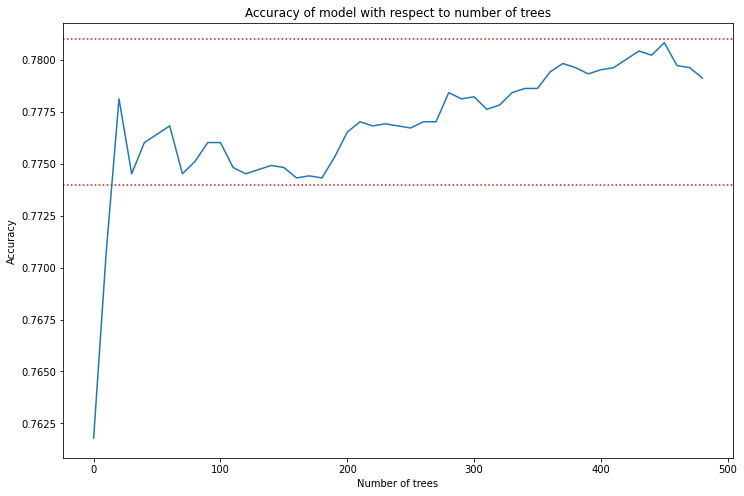

In [135]:
index_trees = list(range(0,len(accuracy)+11, 10))
num_trees = list(range(0, 600, 100))
plt.figure(figsize = (12,8))
plt.plot(accuracy_num_trees)
plt.title("Accuracy of model with respect to number of trees")
plt.xticks(index_trees, num_trees)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.axhline(y=0.774, color='r', linestyle=':')
plt.axhline(y=0.781, color='r', linestyle=':')
plt.show()

Based on the plot, the valdiation accuracy fluctuates mainly within the bound of 77.4% to 78.1%. Hence we can take any number of threes within that bound. To balance both accuracy and time, 300 trees was chosen. 

### 2.2.2 Tuning for depth 

In [136]:
max_depth = list(range(10,30))
time_to_fit_depth = []
accuracy_depth = []

In [137]:
for depth in max_depth:
    start_time = time.perf_counter()
    rf = RandomForestClassifier(random_state=0, oob_score = True, n_estimators = 300, 
                                max_depth = depth, n_jobs = -1).fit(X_train, y_train)
    acc = single_model_multiple_query(rf, X_valid, y_valid, to_print = False)
    end_time = time.perf_counter()
    time_to_fit_depth.append(end_time - start_time)
    accuracy_depth.append(acc)

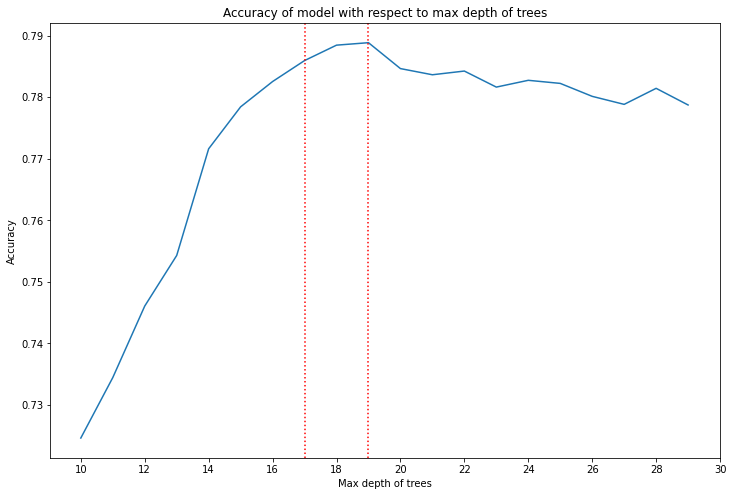

In [173]:
index_depth = list(range(0,len(accuracy_depth)+1, 2))
depth_list = list(range(10, 32, 2))
plt.figure(figsize = (12,8))
plt.plot(accuracy_depth)
plt.title("Accuracy of model with respect to max depth of trees")
plt.xticks(index_depth, depth_list)
plt.xlabel("Max depth of trees")
plt.ylabel("Accuracy")
plt.axvline(x=7, color='r', linestyle=':')
plt.axvline(x=9, color='r', linestyle=':')
plt.show()

Based on the plot, we can see that having a depth of around 17 to 19 would be ideal. Hence we would take the highest possible value of 19.

### 2.2.3 Confirming Tuned Parameters

This is to test the performance of model with respect to the number of trees at the chosen depth. 

In [174]:
num_trees = list(range(250, 350, 10))
time_to_fit_num_trees_2 = []
accuracy_num_trees_2 = []

In [175]:
for num in num_trees:
    start_time = time.perf_counter()
    rf = RandomForestClassifier(random_state=0, oob_score = False, n_estimators = num, 
                                max_depth = 19, n_jobs = -1).fit(X_train, y_train)
    acc = single_model_multiple_query(rf, X_valid, y_valid, to_print = False)
    end_time = time.perf_counter()
    time_to_fit_num_trees_2.append(end_time - start_time)
    accuracy_num_trees_2.append(acc)

In [235]:
index_trees_2 = list(range(0,13,2))
num_trees_2 = list(range(250, 371, 20))

In [236]:
index_trees_2

[0, 2, 4, 6, 8, 10, 12]

In [237]:
num_trees_2

[250, 270, 290, 310, 330, 350, 370]

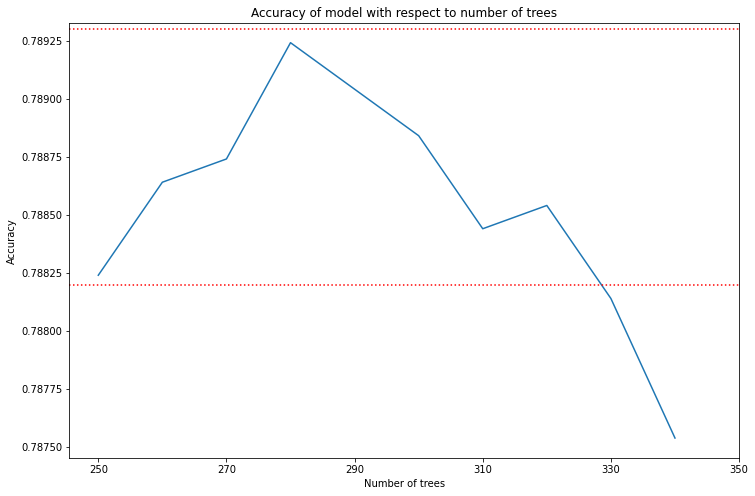

In [244]:
index_trees_2 = list(range(0,11,2))
num_trees_2 = list(range(250, 351, 20))
plt.figure(figsize = (12,8))
plt.plot(accuracy_num_trees_2)
plt.title("Accuracy of model with respect to number of trees")
plt.xticks(index_trees_2, num_trees_2)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.axhline(y=0.7882, color='r', linestyle=':')
plt.axhline(y=0.7893, color='r', linestyle=':')
plt.show()

As with the initial values, the accuracy mainly lines within the 78% region. In fact, we can reduce the number of trees to 280 to increase the validation accuracy slightly. 

## 2.4 Final Model

With the tuning completed, we can combined the training and validation set to train with more data. Then we can test the accuracy on the test set. 

In [247]:
X_train, X_test, y_train, y_test = get_numeric_data(validation_set=False)

In [248]:
start_time = time.perf_counter()
full_rf = RandomForestClassifier(random_state=0, n_estimators = 280, max_depth = 19, n_jobs = -1).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

Time to train decision tree is 2.8885


In [249]:
_ = single_model_multiple_query(full_rf, X_test, y_test)

The accuracy is: 0.7906836964688204
The time taken to predict is 0.2541 seconds


In [250]:
confusion_matrix(y_test, full_rf.predict(X_test))

Actual,Heavy,Medium,Mild,None,Total
Predicted,,,,,
Heavy,434,241,17,69,761
Medium,395,1625,102,253,2375
Mild,22,67,213,76,378
None,251,850,443,8252,9796
Total,1102,2783,775,8650,13310


The full model did very well, achieving an accuracy of about 79%. 

## 2.5. Parallelism 

So here we can time the time taken to train depending on the number of jobs. For reference, the PC that is being used is a quad core with 8 logical processors. Hence the number of jobs can range from 1 to 8. 

In [35]:
book = dict(zip(list(range(1,9)), [[] for i in range(8)]))
num_trees = list(range(100, 1100, 100))

In [36]:
# for i in range(1,9):
#     for x in num_trees:
#         start_time = time.perf_counter()
#         tree = RandomForestClassifier(random_state=0, oob_score = False, n_estimators = x, 
#                             max_depth = 19, n_jobs = i).fit(X, Y)
#         end_time = time.perf_counter()
#         book[i].append(end_time - start_time)

In [60]:
rows = []
for i in range(1,9):
    for x in range(len(num_trees)):
        rows.append((i,x,num_trees[x],book[i][x]))

In [61]:
timings = pd.DataFrame(rows, columns = ["cores", "index", "num_trees", "time"])

In [62]:
timings2 = timings.copy()
timings2["log"] = np.log(timings2.time)

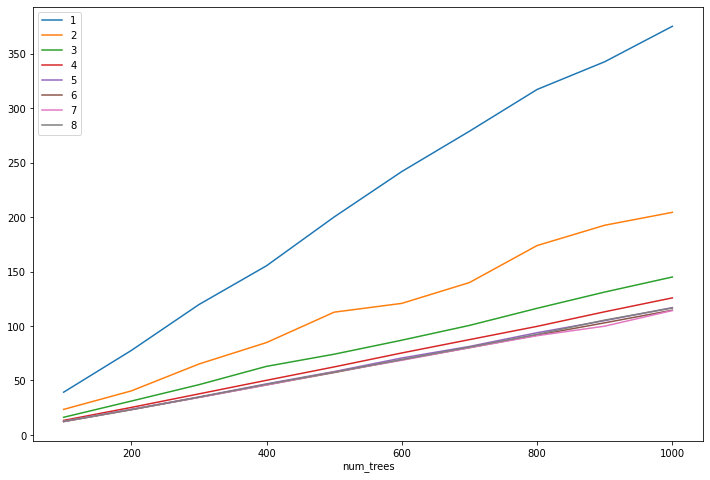

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
for label, df in timings2.groupby("cores"):
    df.plot("num_trees", "time", ax=ax, label=label)
plt.legend();

Locally, we can see that increasing from 1 to 4 cores yield better training performances. This corresponds to the number of physical cores being used increasing. However, from cores 5 to 8, we do no see the same level of time improvement. This could possibly be due to the fact that each core is now "acting as 2 cores" (hyper threading where each physical core constitutes to 2 logical processors). Hence the improvements seen is not significant.  

An interesting point to note is that the computation time linearly increases as the number of trees increase. This is good for scalability as we can linearly scale out more machines if the number of trees needed for the model increases. 

# 3. Random Forest (Spark) 

In this section, we will repeat the above process but using spark. Here, we more interested in the time taken to train and the impact of parallelisation. 